# Decision Dependent Games Simulation
## Synthetic Linear Regression Problem with Location Families

We extend the linear regression example from Miller et. al. (http://arxiv.org/abs/2102.08570) to the multiplayer framework where the models of each player affect the distributions of data seen by all.

In [1]:
import numpy as np
import sys
import ipdb

sys.path.append("../")

sys.path.append("../utils/")
from utils_functions import *

from dd_game import *
from two_stage_player import *
from dfo_player import *
from solo_player import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

np.random.seed(37)

The performative 2-player linear regression problem is set up as follows. For each player $k\in\{1,2\}$ we generate data

$$x^k \sim \mathcal{N}(0,\Sigma_{x^k}),\quad U^k \sim \mathcal{N}(0,\sigma_{y^k}), \quad y^k = \langle \beta^k, x^k \rangle + \langle \mu^k, \theta^k \rangle + \langle \gamma^k, \theta^{-k} \rangle + U^k$$

Where $x^k\in\mathbb{R}^d, y^k\in\mathbb{R}, U^k\in\mathbb{R}$. The performative effects are given by $\mu^k,\gamma^k$, which are drawn randomly by sampling a vector from the radius $\varepsilon^k$ spheres in $\mathbb{R}^{d_1+d_2}$ so that the distribution map for each player $k\in\{1,2\}$ is $\varepsilon^k$-sensitive.
$$\varepsilon^k = \sqrt{||\mu^k||_2^2+||\gamma^k||_2^2}$$
\
The loss function is quadratic
$$\ell((x^k,y^k);\theta^k) = \tfrac{1}{2}(y^k-{x^k}^T\theta^k)^2 = \tfrac{1}{2}||y^k||_2^2+\tfrac{1}{2}||{x^k}^T\theta^k||_2^2-y^k{x^k}^T\theta^k$$
so it is $1$-strongly convex in $\theta^k$ and $1$-smooth in $z^k$  
\
We showed that if $\ell^k(z^k,\theta^k)$ is $\eta^k$-strongly convex in $\theta^k$, is $\beta^k$-smooth in $z^k$, and the distribution map is $\varepsilon^k$-sensitive, then the game is convex, and $PR^k(\theta^k)$ for each player $k\in\{1,2\}$ is $\lambda^k$-weakly convex where $$\lambda^k=2\beta^k\varepsilon^k-\eta^k$$
If the performative risks are both strongly convex, then the game is diagonally strictly convex, so the game will have a unique Nash equilibrium, so we can enforce DSC by choosing parameters such that
$$2\beta^k\varepsilon^k\leq\eta^k$$
That is,
$$\varepsilon^k\leq\frac{1}{2} \iff DSC$$

# Configurations

In [2]:
d_1 = 2  # Dimension of each player's data/strategy
d_2 = 2

epsilon_0 = 0.3
epsilon_1 = 0.3  # Epsilon sensitivity parameters
epsilon_2 = 0.3

Sigma_x_p1 = np.eye(d_1)  # Covariance of x^k
Sigma_x_p2 = np.eye(d_2)

sigma_y_p1 = 0.1  # Variance of y^k
sigma_y_p2 = 0.1

beta_p1 = np.random.normal(size=d_1)  # Linear parameter vector
beta_p2 = np.random.normal(size=d_2)

# s_1 = sample_sphere(epsilon_1,d_1+d_2)  # Performativity parameters
# mu_p1 = s_1[0:d_1]
# gamma_p1 = s_1[d_1:]
# s_2 = sample_sphere(epsilon_2,d_1+d_2)
# mu_p2 = s_2[0:d_2]
# gamma_p2 = s_2[d_2:]

mu_p1 = sample_sphere(epsilon_0,d_1)
gamma_p1 = sample_sphere(epsilon_1,d_2)
mu_p2 = sample_sphere(epsilon_0,d_2)
gamma_p2 = sample_sphere(epsilon_2,d_1)

In [3]:
p1_data_params = (Sigma_x_p1, sigma_y_p1, beta_p1, mu_p1, gamma_p1)
p1_data_generating_func = sample_from_location_family

p2_data_params = (Sigma_x_p2, sigma_y_p2, beta_p2, mu_p2, gamma_p2)
p2_data_generating_func = sample_from_location_family

In [4]:
num_rounds_lst = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000]
num_alternate_rounds = 100
num_test = 1000

# Run game with 2-stage algorithm

In [5]:
p1_risks = []
p2_risks = []
theta_final_p1 = []
theta_final_p2 = []

for num_rounds in num_rounds_lst:
    print(f"num_rounds = {num_rounds}")
    player_two = TwoStagePlayer()
    player_one = TwoStagePlayer()
    game = DecisionDependentGame(player_one, player_two,
                                 p1_data_params, p2_data_params,
                                 p1_data_generating_func, p2_data_generating_func,
                                 num_rounds, num_alternate_rounds, num_test)
    
    game.run_train()
    game.run_post_train_alternating()
    
    PR1, PR2 = game.evaluate_closed_perf_risk()
    p1_risks.append(PR1)
    p2_risks.append(PR2)
    
    theta_final_p1.append(game.theta_p1)
    theta_final_p2.append(game.theta_p2)
    
    #Change this flag if one wants to change print settings
    if False:
        print("---------------------")
        print("Player 1: Actual mu, gamma")
        print(mu_p1, gamma_p1)
        print("Player 1: Estimated mu, gamma")
        print(player_one.mu_hat, player_one.gamma_hat)

        print("Player 2: Actual mu, gamma")
        print(mu_p2, gamma_p2)
        print("Player 2: Estimated mu, gamma")
        print(player_two.mu_hat, player_two.gamma_hat)
        print("---------------------")

num_rounds = 10
num_rounds = 50
num_rounds = 100
num_rounds = 500
num_rounds = 1000
num_rounds = 5000
num_rounds = 10000
num_rounds = 50000
num_rounds = 100000


# Run game with DFO players

In [6]:
p3_risks = []
p4_risks = []

delta = 1e-0
eta = 1e-1
num_rounds = num_rounds_lst[-1]

player_three = DFOPlayer(delta,eta)
player_four = DFOPlayer(delta,eta)
game_dfo = DecisionDependentGame(player_three, player_four,
                                 p1_data_params, p2_data_params,
                                 p1_data_generating_func, p2_data_generating_func)

for i in range(num_rounds+1):
    
    game_dfo.theta_p1 = player_three.perturb_theta()
    game_dfo.theta_p2 = player_four.perturb_theta()
    
    PR_3_oracle, PR_4_oracle = game_dfo.evaluate_closed_perf_risk()
    
    game_dfo.theta_p1 = player_three.update_theta(PR_3_oracle)
    game_dfo.theta_p2 = player_four.update_theta(PR_4_oracle)
    
    if i in num_rounds_lst:
        p3_risks.append(PR_3_oracle)
        p4_risks.append(PR_4_oracle)
    
    if False:  # i%(num_rounds/5)==0:
        print("---------------------")
        print(f"Iteration {i}")
        print("Player 3 risk:")
        print(PR_3_oracle)

        print("Player 4 risk")
        print(PR_4_oracle)

# Run Game With Solo Players

In [7]:
p5_risks = []
p6_risks = []
theta_final_p5 = []
theta_final_p6 = []

for num_rounds in num_rounds_lst:
    print(f"num_rounds = {num_rounds}")
    player_five = SoloPlayer()
    player_six = SoloPlayer()
    game = DecisionDependentGame(player_five, player_six,
                                 p1_data_params, p2_data_params,
                                 p1_data_generating_func, p2_data_generating_func,
                                 num_rounds, num_alternate_rounds, num_test)
    
    game.run_train()
    game.run_post_train_alternating()
    
    PR1, PR2 = game.evaluate_closed_perf_risk()
    p5_risks.append(PR1)
    p6_risks.append(PR2)
    
    theta_final_p5.append(game.theta_p1)
    theta_final_p6.append(game.theta_p2)
    
    #Change this flag if one wants to change print settings
    if False:
        print("---------------------")
        print("Player 1: Actual mu, gamma")
        print(mu_p1, gamma_p1)
        print("Player 1: Estimated mu, gamma")
        print(player_one.mu_hat, player_one.gamma_hat)

        print("Player 2: Actual mu, gamma")
        print(mu_p2, gamma_p2)
        print("Player 2: Estimated mu, gamma")
        print(player_two.mu_hat, player_two.gamma_hat)
        print("---------------------")

num_rounds = 10
num_rounds = 50
num_rounds = 100
num_rounds = 500
num_rounds = 1000
num_rounds = 5000
num_rounds = 10000
num_rounds = 50000
num_rounds = 100000


In [8]:
theta_PO_1, theta_PO_2 = game.solve_nash()
theta_SO_1, theta_SO_2 = game.solve_social_opt()
theta_final_p1 = np.array(theta_final_p1)
theta_final_p2 = np.array(theta_final_p2)
theta_final_p5 = np.array(theta_final_p5)
theta_final_p6 = np.array(theta_final_p6)

In [9]:
if False:
    print(mu_p1, gamma_p1)
    print(player_one.mu_hat.round(2), player_one.gamma_hat.round(2))

    print(mu_p2, gamma_p2)
    print(player_two.mu_hat.round(2), player_two.gamma_hat.round(2))

    print(game.solve_nash())
    print(game.solve_social_opt())
    
    print(game.evaluate_test_perf_risk_p1().round(3))
    print(game.evaluate_test_perf_risk_p2().round(3))

In [10]:
game.theta_p1, game.theta_p2 = game.solve_nash()
PO_1, PO_2 = game.evaluate_closed_perf_risk()
print(f'Player 1 PO = {PO_1.round(3)}\tPlayer 2 PO = {PO_2.round(3)}')

Player 1 PO = 0.141	Player 2 PO = 0.156


In [11]:
game.theta_p1, game.theta_p2 = game.solve_social_opt()
SO_1, SO_2 = game.evaluate_closed_perf_risk()
print(f'Player 1 SO = {SO_1.round(3)}\tPlayer 2 SO = {SO_2.round(3)}')

Player 1 SO = 0.154	Player 2 SO = 0.157


## Checking stage 1

In [12]:
print(player_one.mu_hat, player_one.gamma_hat)
print(player_two.mu_hat, player_two.gamma_hat)

[0.25336554 0.16069776] [ 0.16172076 -0.2613666 ]
[ 0.22370028 -0.19401621] [0.11283648 0.26836746]


In [13]:
print(player_five.mu_hat, player_five.gamma_hat)
print(player_six.mu_hat, player_six.gamma_hat)

[0.25347198 0.16740154] [0. 0.]
[ 0.23059445 -0.18883889] [0. 0.]


In [14]:
print(mu_p1, gamma_p1)
print(mu_p2, gamma_p2)

[0.2513218  0.16382109] [ 0.15789928 -0.25508394]
[ 0.22742193 -0.19565087] [0.11972632 0.27507382]


## Plots

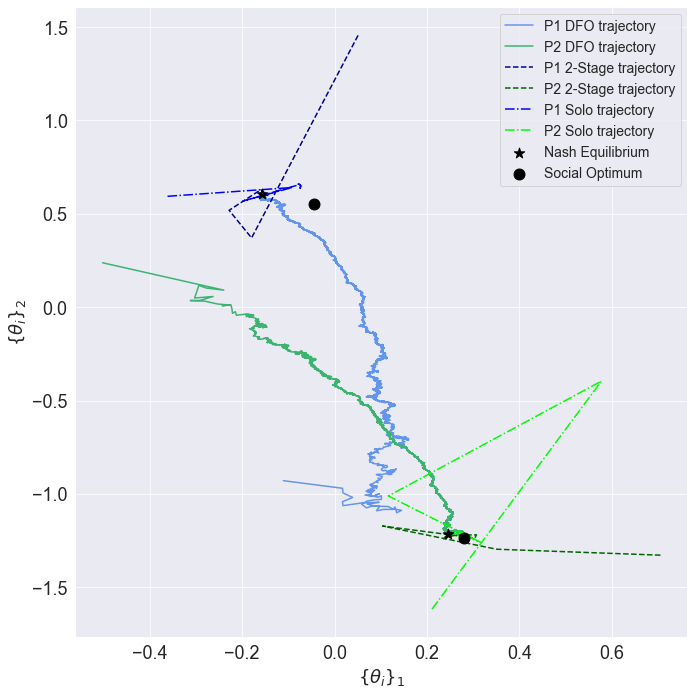

In [16]:
plt.figure(figsize=(10,10))
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

theta_3 = np.array(player_three.theta_history)
plt.plot(theta_3[:,0],theta_3[:,1],
         label='P1 DFO trajectory', color='cornflowerblue')

theta_4 = np.array(player_four.theta_history)
plt.plot(theta_4[:,0],theta_4[:,1],
        label='P2 DFO trajectory', color='mediumseagreen')

x2 = theta_final_p1[:,0]
y2 = theta_final_p1[:,1]
plt.plot(x2,y2,
         '--', color='darkblue', label='P1 2-Stage trajectory')

x3 = theta_final_p2[:,0]
y3 = theta_final_p2[:,1]
plt.plot(x3,y3,
         '--', color='darkgreen', label='P2 2-Stage trajectory')

x5 = theta_final_p5[:,0]
y5 = theta_final_p5[:,1]
plt.plot(x5,y5,
         '-.', color='blue', label='P1 Solo trajectory')

x6 = theta_final_p6[:,0]
y6 = theta_final_p6[:,1]
plt.plot(x6,y6,
         '-.', color='lime', label='P2 Solo trajectory')

x_nash_p1 = theta_PO_1[0]
y_nash_p1 = theta_PO_1[1]
plt.scatter(x_nash_p1, y_nash_p1,
            label='Nash Equilibrium', marker='*', color='k', s=120, zorder=10)

x_nash_p2 = theta_PO_2[0]
y_nash_p2 = theta_PO_2[1]
plt.scatter(x_nash_p2,y_nash_p2,
            marker='*', color='k', s=120, zorder=10)

x_so_p1 = theta_SO_1[0]
y_so_p1 = theta_SO_1[1]
plt.scatter(x_so_p1, y_so_p1,
            label='Social Optimum', marker='o', color='k', s=120, zorder=10)

x_so_p2 = theta_SO_2[0]
y_so_p2 = theta_SO_2[1]
plt.scatter(x_so_p2,y_so_p2,
            marker='o', color='k', s=120, zorder=10)

plt.legend(loc='best',fontsize=14)
plt.xlabel(r"$\{\theta_i\}_1$")
plt.ylabel(r"$\{\theta_i\}_2$")
plt.tight_layout()
plt.savefig('../figures/DD_regression_trajectory.pdf', format='pdf')
plt.show()

In [ ]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.semilogx(num_rounds_lst, [PO_1 for i in num_rounds_lst],
             '-', color='k', label='P1 Performative Optimum')
plt.semilogx(num_rounds_lst, [PO_2 for i in num_rounds_lst],
             '-', color='k', label='P2 Performative Optimum') 

plt.semilogx(num_rounds_lst[1:], p1_risks[1:],
             '--', color='#5553E6', label='P1 Performative Risk')
plt.semilogx(num_rounds_lst[1:], p2_risks[1:],
             '--', color='#E07110', label='P2 Performative Risk')

plt.semilogx(num_rounds_lst, p3_risks,
             '-', color='#5553E6', label='P1 DFO Performative Risk')
plt.semilogx(num_rounds_lst, p4_risks,
             '-', color='#E07110', label='P2 DFO Performative Risk')

plt.semilogx(num_rounds_lst, p5_risks,
             '-.', color='#5553E6', label='P1 Solo Performative Risk')
plt.semilogx(num_rounds_lst, p6_risks,
             '-.', color='#E07110', label='P2 Solo Performative Risk')
plt.xlabel("Iterations")
plt.ylabel(r"$PR(\theta)$")
plt.title("Evolution of Performative Risks")
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.loglog(num_rounds_lst, [PO_1 for i in num_rounds_lst],
           '-', color='k', label='P1 Performative Optimum')
plt.loglog(num_rounds_lst, [PO_2 for i in num_rounds_lst],
           '-', color='k', label='P2 Performative Optimum')

plt.loglog(num_rounds_lst[1:], p1_risks[1:],
           '--', color='#5553E6', label='P1 Performative Risk')
plt.loglog(num_rounds_lst[1:], p2_risks[1:],
           '--', color='#E07110', label='P2 Performative Risk')

plt.loglog(num_rounds_lst, p3_risks,
           '-', color='#5553E6', label='P1 DFO Performative Risk')
plt.loglog(num_rounds_lst, p4_risks,
           '-', color='#E07110', label='P2 DFO Performative Risk')

plt.loglog(num_rounds_lst, p5_risks,
           '-.', color='#5553E6', label='P1 Solo Performative Risk')
plt.loglog(num_rounds_lst, p6_risks,
           '-.', color='#E07110', label='P2 Solo Performative Risk')
plt.ylabel(r"$\log(PR(\theta))$")
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
plt.semilogy([t for t in range(len(player_one.theta_history))],np.linalg.norm(theta_PO_1-np.array(player_one.theta_history),axis=1),label='Player 1')
plt.semilogy([t for t in range(len(player_two.theta_history))],np.linalg.norm(theta_PO_2-np.array(player_two.theta_history),axis=1),label='Player 2')
plt.title("2-Stage Distance to Nash vs. Iteration")
plt.ylabel(r"$\log||\theta - \theta_{PO}||_2$")
plt.xlabel(r"t")
plt.legend()
plt.subplot(2,2,2)
plt.loglog([t for t in range(len(player_one.theta_history))],np.linalg.norm(theta_PO_1-np.array(player_one.theta_history),axis=1),label='Player 1')
plt.loglog([t for t in range(len(player_two.theta_history))],np.linalg.norm(theta_PO_2-np.array(player_two.theta_history),axis=1),label='Player 2')
plt.title("2-Stage Distance to Nash vs. Iteration")
plt.ylabel(r"$\log||\theta - \theta_{PO}||_2$")
plt.xlabel(r"$\log t$")
plt.legend()
plt.subplot(2,2,3)
plt.semilogy([t for t in range(len(player_three.theta_history))],np.linalg.norm(theta_PO_1-np.array(player_three.theta_history),axis=1),label='Player 1')
plt.semilogy([t for t in range(len(player_four.theta_history))],np.linalg.norm(theta_PO_2-np.array(player_four.theta_history),axis=1),label='Player 2')
plt.title("DFO Distance to Nash vs. Iteration")
plt.ylabel(r"$\log||\theta - \theta_{PO}||_2$")
plt.xlabel(r"t")
plt.legend()
plt.subplot(2,2,4)
plt.loglog([t for t in range(len(player_three.theta_history))],np.linalg.norm(theta_PO_1-np.array(player_three.theta_history),axis=1),label='Player 1')
plt.loglog([t for t in range(len(player_four.theta_history))],np.linalg.norm(theta_PO_2-np.array(player_four.theta_history),axis=1),label='Player 2')
plt.title("DFO Distance to Nash vs. Iteration")
plt.ylabel(r"$\log||\theta - \theta_{PO}||_2$")
plt.xlabel(r"$\log t$")
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
labels = [r'$PR_{2stage}$', r'$PR_{solo}$', r'$PR_{DFO}$', r'$PO$', r'$SO$']
plt.bar((1,2,3,4,5), (p1_risks[-1],p5_risks[-1],p3_risks[-1],PO_1,SO_1),
        label='P1', tick_label=labels, color='#5553E6')
plt.bar((1,2,3,4,5), (p2_risks[-1],p6_risks[-1],p4_risks[-1],PO_2,SO_2),
        bottom=(p1_risks[-1],p5_risks[-1],p3_risks[-1],PO_1,SO_1),
        label='P2', color='#E07110')
plt.title('Total Performative Risk')
plt.ylabel(r'$PR(\theta)$')
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()